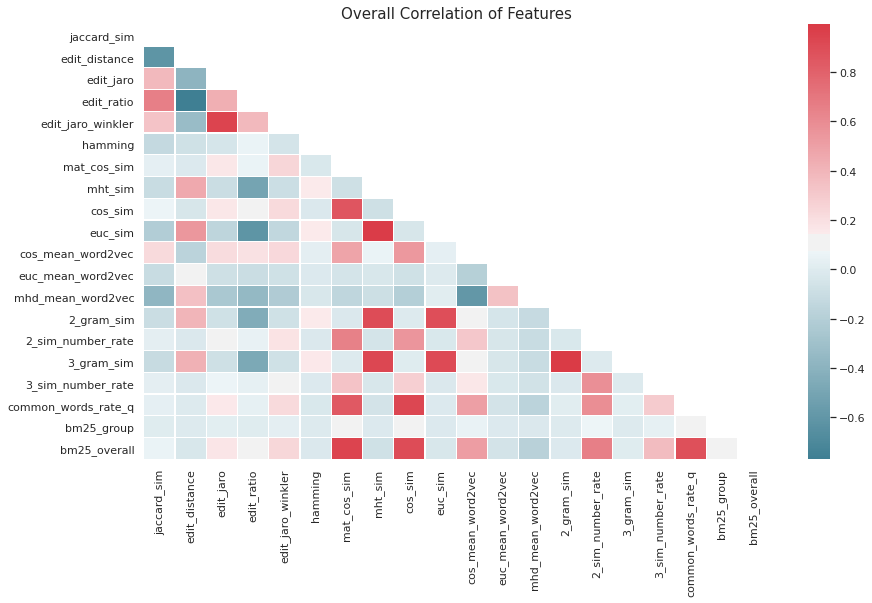

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

train = pd.read_csv('./data/train/features_50.csv')
feat_name = []
for col in train:
    if 'feat_' in col:
        feat_name.append(col)
        
train = train[feat_name]
feat_name = [feat[5:] for feat in feat_name]
for i in range(len(feat_name)):
    if 'query_token' in feat_name[i]:
        feat_name[i] = feat_name[i][12:]
train.columns = feat_name

corr = train.corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of Features', fontsize=15)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap=cmap, linewidths=0.2, annot_kws={'size':20})
plt.savefig('./test.png')
plt.show()

In [21]:
csv_file_list = ['./data/train/validation_30.csv', './data/train/validation_50.csv', './data/train/features_30.csv', './data/train/features_50.csv']
del_feat_name = ['ls_local_begin', 'ls_local_mean', 'ls_total_loc', 'ls_density', 'ls_rate_q_len', 'ls_rate_t_len', 'query_token_matched_cnt', 'query_token_matched_cnt_ratio', 'ls_max_count', 'common_words', 'common_words_rate_d', 'unique_rate', 'same_len_rate', 'same_word_q', 'same_word_t', 'q_loc', 't_loc', 'same_w_set_q', 'set_rate', 'loc_set_t', 'same_w_set_t', 'loc_set_q', 'word_set_rate']
del_feat_name = ['tf_cos_sim', 'tf_mht_sim', 'tf_euc_sim']
for csv_file in csv_file_list:
    feature_pd = pd.read_csv(csv_file)
    print('Processing ' + csv_file)
    for feat in del_feat_name:
        try:
            del feature_pd['feat_' + feat]
        except:
            pass
    feature_pd.to_csv(csv_file, index=False)
    feature_pd

Processing ./data/train/validation_30.csv
Processing ./data/train/validation_50.csv
Processing ./data/train/features_30.csv
Processing ./data/train/features_50.csv


In [27]:
len(['ls_local_begin', 'ls_local_mean', 'ls_total_loc', 'ls_density', 'ls_rate_q_len', 'ls_rate_t_len', 'query_token_matched_cnt', 'query_token_matched_cnt_ratio', 'ls_max_count', 'common_words', 'common_words_rate_d', 'unique_rate', 'same_len_rate', 'same_word_q', 'same_word_t', 'q_loc', 't_loc', 'same_w_set_q', 'set_rate', 'loc_set_t', 'same_w_set_t', 'loc_set_q', 'word_set_rate'])


23

# Utils

In [1]:
import pandas as pd
from gensim import corpora, similarities, models
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.summarization.bm25 import BM25
import time
import numpy as np
import math
import collections
from multiprocessing import cpu_count, Pool
import Levenshtein
import textdistance
import json
from preprocess import TextPreprocessor as TPP
from unidecode import unidecode
import nltk

'''
    Initialize models
'''
print('Loading models...')
vec_model_path = './model/Word2Vec/GoogleNews-vectors-negative300.bin.gz'

g_vec_model = models.KeyedVectors.load_word2vec_format(vec_model_path, binary=True)
g_dictionary = corpora.Dictionary.load('./model/Word2Vec/dictionary.dict')
g_tfidf_model = models.TfidfModel.load("./model/Word2Vec/tfidf.model")
g_index = similarities.SparseMatrixSimilarity.load('./model/Word2Vec/index.index')
print('Loaded')
'''
    Pool all text from documents
'''
csv_folder = './data/csv/'
document_csv_file = csv_folder + 'documents.csv'
document_pd = pd.read_csv(document_csv_file)

# pool all items from documents
raw_text = document_pd['doc_text'].values.tolist()
text_pool = [line.split() for line in raw_text]

from collections import defaultdict
# Remove words appear once
word_freq = defaultdict(int)
for line in text_pool:
    for word in line:
        word_freq[word] += 1
text_pool = [[token for token in line if word_freq[token] > 1] for line in text_pool]

'''
    Load BM25 model
'''
from gensim.corpora.mmcorpus import MmCorpus
from gensim.test.utils import datapath

dict_path = './model/Word2Vec/'

print('Initialize BM25 model')
g_corpus = MmCorpus(dict_path + 'corpus.mm')
g_bm25_model = BM25(text_pool)
print('BM25 loaded')

'''
    Features computation utils
'''
def get_len(x):
    '''
        Length of tokens
    '''
    x = x.split()
    return len(x)


def get_token_cnt(x, y):
    '''
        Compute times of each token of y appeared in x
    '''
    x = x.split()
    y = y.split()
    num = 0
    for i in y:
        if i in x:
            num += 1
    return num


def get_token_cnt_ratio(x, y):
    x = x.split()
    return y / len(x)


def get_jaccard_sim(x, y):
    '''
        Jaccard Similarity between x & y
    '''
    x = set(x)
    y = set(y)
    return float(len(x & y) / len(x | y))


def get_mat_cos_sim(doc, corpus):
    '''
        Cosine Similarity between x & y
    '''
    doc = doc.split(' ')
    corpus = corpus.split(' ')

    corpus_vec = [g_dictionary.doc2bow(corpus)]
    vec = g_dictionary.doc2bow(doc)

    corpus_tfidf = g_tfidf_model[corpus_vec]
    vec_tfidf = g_tfidf_model[vec]

    num_features = len(g_dictionary.token2id.keys())
    mat_index = similarities.SparseMatrixSimilarity(corpus_tfidf, num_features=num_features)
    sim = mat_index.get_similarities(vec_tfidf)

    return sim[0]


def get_weight_counter_and_tf_idf(x, y):
    x = x.split()
    y = y.split()
    corups = x + y
    obj = dict(collections.Counter(corups))
    x_weight = []
    y_weight = []
    idfs = []
    for key in obj.keys():
        idf = 1
        w = obj[key]
        if key in x:
            idf += 1
            x_weight.append(w)
        else:
            x_weight.append(0)
        if key in y:
            idf += 1
            y_weight.append(w)
        else:
            y_weight.append(0)
        idfs.append(math.log(3.0 / idf) + 1)
    return [np.array(x_weight), np.array(y_weight), np.array(x_weight) * np.array(idfs), np.array(y_weight) * np.array(idfs), np.array(list(obj.keys()))]


def get_manhattan_distance(x, y):
    '''
        Manhattan distance
    '''
    return np.linalg.norm(x - y, ord=1)


def get_manhattan_distance_by_id(query_id, doc_id):
    '''
        Manhattan distance
    '''
    x = get_vec_by_query_id(query_id)
    y = get_vec_by_doc_id(doc_id)
    return np.linalg.norm(x - y, ord=1)
    

def get_cos_sim(x, y):
    '''
        Cosine similarity between vectors
    '''
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def get_cos_sim_by_id(query_id, doc_id):
    '''
        Cosine similarity between vectors
    '''
    x = get_vec_by_query_id(query_id)
    y = get_vec_by_doc_id(doc_id)
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

   
def get_euclidean_sim(x, y):
    '''
        Euclidean similarity between vectors
    '''
    return np.sqrt(np.sum(x - y) ** 2)


def get_euclidean_sim_by_id(query_id, doc_id):
    '''
        Euclidean similarity between vectors
    '''
    x = get_vec_by_query_id(query_id)
    y = get_vec_by_doc_id(doc_id)
    return np.sqrt(np.sum(x - y) ** 2)


def get_tfidf_sim(query, doc):
    '''
        TF-IDF
    '''
    weight = list(map(lambda x, y: get_weight_counter_and_tf_idf(x, y), tqdm(query), doc))
    x_weight_couner = []
    y_weight_couner = []
    x_weight_tfidf = []
    y_weight_tfidf = []
    words = []
    for i in weight:
        x_weight_couner.append(i[0])
        y_weight_couner.append(i[1])
        x_weight_tfidf.append(i[2])
        y_weight_tfidf.append(i[3])
        words.append(i[4])

    mht_sim_counter = list(map(lambda x, y: get_manhattan_distance(x, y), x_weight_couner, y_weight_couner))
    mht_sim_tfidf = list(map(lambda x, y: get_manhattan_distance(x, y), x_weight_tfidf, y_weight_tfidf))

    cos_sim_counter = list(map(lambda x, y: get_cos_sim(x, y), x_weight_couner, y_weight_couner))
    cos_sim_tfidf = list(map(lambda x, y: get_cos_sim(x, y), x_weight_tfidf, y_weight_tfidf))

    euclidean_sim_counter = list(map(lambda x, y: get_euclidean_sim(x, y), x_weight_couner, y_weight_couner))
    euclidean_sim_tfidf = list(map(lambda x, y: get_euclidean_sim(x, y), x_weight_tfidf, y_weight_tfidf))

    return mht_sim_counter, mht_sim_tfidf, cos_sim_counter, cos_sim_tfidf, euclidean_sim_counter, euclidean_sim_tfidf


def get_word_vec(x):
    '''
        Word2Vec
    '''
    vec = []
    for word in x.split():
        if word in g_vec_model:
            vec.append(g_vec_model[word])
    if len(vec) == 0:
        return np.nan
    else:
        return np.mean(np.array(vec), axis=0)


def get_df_grams(train_sample, values, cols):
    def create_ngram_set(input_list, ngram_value):
        return set(zip(*[input_list[i:] for i in range(ngram_value)]))

    def get_n_gram(df, values):
        train_query = df.values
        train_query = [[word for word in str(sen).replace("'", '').split(' ')] for sen in train_query]
        train_query_n = []
        for input_list in train_query:
            train_query_n_gram = set()
            for value in range(values, values + 1):
                train_query_n_gram = train_query_n_gram | create_ngram_set(input_list, value)
            train_query_n.append(train_query_n_gram)
        return train_query_n

    train_query = get_n_gram(train_sample[cols[0]], values)
    train_title = get_n_gram(train_sample[cols[1]], values)
    sim = list(map(lambda x, y: len(x) + len(y) - 2 * len(x & y), train_query, train_title))
    sim_number_rate = list(map(lambda x, y:   len(x & y) / len(x) if len(x) != 0 else 0, train_query, train_title))
    return sim, sim_number_rate


def get_token_matched_features(query, title):
    q_list = query.split()
    t_list = title.split()
    set_query = set(q_list)
    set_title = set(t_list)
    count_words = len(set_query.union(set_title))

    comwords = [word for word in t_list if word in q_list]
    comwords_set = set(comwords)
    unique_rate = len(comwords_set) / count_words

    same_word1 = [w for w in q_list if w in t_list]
    same_word2 = [w for w in t_list if w in q_list]
    same_len_rate = (len(same_word1) + len(same_word2)) / \
        (len(q_list) + len(t_list))
    if len(comwords) > 0:
        com_index1 = len(comwords)
        same_word_q = com_index1 / len(q_list)
        same_word_t = com_index1 / len(t_list)

        for word in comwords_set:
            index_list = [i for i, x in enumerate(q_list) if x == word]
            com_index1 += sum(index_list)
        q_loc = com_index1 / (len(q_list) * len(comwords))
        com_index2 = len(comwords)
        for word in comwords_set:
            index_list = [i for i, x in enumerate(t_list) if x == word]
            com_index2 += sum(index_list)
        t_loc = com_index2 / (len(t_list) * len(comwords))

        same_w_set_q = len(comwords_set) / len(set_query)
        same_w_set_t = len(comwords_set) / len(set_title)
        word_set_rate = 2 * len(comwords_set) / \
            (len(set_query) + len(set_title))

        com_set_query_index = len(comwords_set)
        for word in comwords_set:
            index_list = [i for i, x in enumerate(q_list) if x == word]
            if len(index_list) > 0:
                com_set_query_index += index_list[0]
        loc_set_q = com_set_query_index / (len(q_list) * len(comwords_set))
        com_set_title_index = len(comwords_set)
        for word in comwords_set:
            index_list = [i for i, x in enumerate(t_list) if x == word]
            if len(index_list) > 0:
                com_set_title_index += index_list[0]
        loc_set_t = com_set_title_index / (len(t_list) * len(comwords_set))
        set_rate = (len(comwords_set) / len(comwords))
    else:
        unique_rate, same_len_rate, same_word_q, same_word_t, q_loc, t_loc, same_w_set_q, same_w_set_t, word_set_rate, loc_set_q, loc_set_t, set_rate = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    return unique_rate, same_len_rate, same_word_q, same_word_t, q_loc, t_loc, same_w_set_q, same_w_set_t, word_set_rate, loc_set_q, loc_set_t, set_rate


def get_substr_features(query, title):
    q_list = query.split()
    query_len = len(q_list)
    t_list = title.split()
    title_len = len(t_list)
    count1 = np.zeros((query_len + 1, title_len + 1))
    index = np.zeros((query_len + 1, title_len + 1))
    for i in range(1, query_len + 1):
        for j in range(1, title_len + 1):
            if q_list[i - 1] == t_list[j - 1]:
                count1[i][j] = count1[i - 1][j - 1] + 1
                index[i][j] = index[i - 1][j - 1] + j
            else:
                count1[i][j] = 0
                index[i][j] = 0
    max_count1 = count1.max()

    if max_count1 != 0:
        row = int(np.where(count1 == np.max(count1))[0][0])
        col = int(np.where(count1 == np.max(count1))[1][0])
        mean_pos = index[row][col] / (max_count1 * title_len)
        begin_loc = (col - max_count1 + 1) / title_len
        rows = np.where(count1 != 0.0)[0]
        cols = np.where(count1 != 0.0)[1]
        total_loc = 0
        for i in range(0, len(rows)):
            total_loc += index[rows[i]][cols[i]]
        density = total_loc / (query_len * title_len)
        rate_q_len = max_count1 / query_len
        rate_t_len = max_count1 / title_len
    else:
        begin_loc, mean_pos, total_loc, density, rate_q_len, rate_t_len = 0, 0, 0, 0, 0, 0
    return max_count1, begin_loc, mean_pos, total_loc, density, rate_q_len, rate_t_len


def get_common_words(query, title):
    query = set(query.split())
    title = set(title.split())
    return len(query & title)


def get_bm25_group(df):
    '''
        Build BM25 model for each query group
    '''
    df.columns = ['query_id', 'query_text', 'doc_text']
    df['query_id'] = df['query_id'].fillna('always_nan')
    query_id_group = df.groupby(['query_id'])
    bm_list = []
    for name, group in tqdm(query_id_group):
        group_corpus = group['doc_text'].values.tolist()
        group_corpus = [sentence.strip().split() for sentence in group_corpus]
        query = group['query_text'].values[0].strip().split()
        group_bm25_model = BM25(group_corpus)
        bm_score = group_bm25_model.get_scores(query)
        bm_list.extend(bm_score)

    return bm_list

def get_bm25_overall(doc_id, query_text):
    '''
        Compute BM25 with model over all documents
    '''
    score = g_bm25_model.get_score(query_text.split(' '), doc_id2idx[doc_id])
    return score

def get_vec_by_query_id(query_id):
    return query_pd['query_vec'][query_id2idx[query_id]]

def get_vec_by_doc_id(doc_id):
    return document_pd['doc_vec'][doc_id2idx[doc_id]]

def get_features(feature_data):
    '''
        Compute all features
    '''
    tic = time.time()
    data = feature_data.copy()
    feat_prefix = 'feat_'

    # get text for each id
    data['query_text'] = data['query_id'].apply(lambda query_id: query_map[query_id])
    data['doc_text'] = data['doc_id'].apply(lambda doc_id: document_map[doc_id])
    
    data['query_len'] = data['query_text'].apply(get_len)
    data['doc_len'] = data['doc_text'].apply(get_len)

    data[feat_prefix + 'jaccard_sim'] = list(map(get_jaccard_sim, data['query_text'], data['doc_text']))
    data[feat_prefix + 'edit_distance'] = list(map(lambda x, y: Levenshtein.distance(x, y) / (len(x) + 1), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'edit_jaro'] = list(map(lambda x, y: Levenshtein.jaro(x, y), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'edit_ratio'] = list(map(lambda x, y: Levenshtein.ratio(x, y), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'edit_jaro_winkler'] = list(map(lambda x, y: Levenshtein.jaro_winkler(x, y), tqdm(data['query_text']), data['doc_text']))
    data[feat_prefix + 'hamming'] = list(map(lambda x, y: textdistance.Hamming(qval=None).normalized_distance(x, y), tqdm(data['query_text']), data['doc_text']))

    data[feat_prefix + 'mat_cos_sim'] = list(map(lambda x, y: get_mat_cos_sim(x, y), tqdm(data['query_text']), data['doc_text']))

    data[feat_prefix + 'mht_sim'], data[feat_prefix + 'tf_mht_sim'], \
    data[feat_prefix + 'cos_sim'], data[feat_prefix + 'tf_cos_sim'], \
    data[feat_prefix + 'euc_sim'], data[feat_prefix + 'tf_euc_sim'] \
        = get_tfidf_sim(data['query_text'], data['doc_text'])
    
    data[feat_prefix + '2_gram_sim'], data[feat_prefix + '2_sim_number_rate'] = get_df_grams(data, 2, ['query_text', 'doc_text'])
    data[feat_prefix + '3_gram_sim'], data[feat_prefix + '3_sim_number_rate'] = get_df_grams(data, 3, ['query_text', 'doc_text'])
    
    data[feat_prefix + '2_gram_sim'], data[feat_prefix + '2_sim_number_rate'] = get_df_grams(data, 2, ['query_text', 'doc_text'])
    data[feat_prefix + 'query_token_matched_cnt'] = list(map(get_token_cnt, data['doc_text'], data['query_text']))
    data[feat_prefix + 'query_token_matched_cnt_ratio'] = list(map(get_token_cnt_ratio, data['query_text'], data['feat_query_token_matched_cnt']))
    data[feat_prefix + "ls_max_count"], data[feat_prefix + "ls_local_begin"], data[feat_prefix + "ls_local_mean"], data[feat_prefix+"ls_total_loc"], data[feat_prefix + "ls_density"], data[feat_prefix + "ls_rate_q_len"], data[feat_prefix + "ls_rate_t_len"] = zip(*data.apply(lambda line: get_substr_features(line["query_text"], line["doc_text"]), axis=1))
    data[feat_prefix + 'common_words'] = list(map(get_common_words, data['doc_text'], data['query_text']))
    data[feat_prefix + 'common_words_rate_q'] = data[feat_prefix + 'common_words'] / data['query_len']
    data[feat_prefix + 'common_words_rate_d'] = data[feat_prefix + 'common_words'] / data['doc_len']
    data[feat_prefix + "unique_rate"], data[feat_prefix + "same_len_rate"], data[feat_prefix + "same_word_q"], data[feat_prefix + "same_word_t"], data[feat_prefix + "q_loc"], data[feat_prefix + "t_loc"], data[feat_prefix + "same_w_set_q"], data[feat_prefix + "same_w_set_t"], data[feat_prefix + "word_set_rate"], data[feat_prefix + "loc_set_q"], data[feat_prefix + "loc_set_t"], data[feat_prefix + "set_rate"] = zip(*data.apply(lambda line: get_token_matched_features(line["query_text"], line["doc_text"]), axis=1))
    
    data[feat_prefix + 'bm25_group'] = get_bm25_group(data[['query_id', 'query_text', 'doc_text']])
    data[feat_prefix + 'bm25_overall'] = list(map(get_bm25_overall, tqdm(data['doc_id']), data['query_text']))
    
    data[feat_prefix + 'cos_mean_word2vec'] = list(map(get_cos_sim_by_id, tqdm(data['query_id']), data['doc_id']))
    data[feat_prefix + 'cos_mean_word2vec'] = data[feat_prefix + 'cos_mean_word2vec'].apply(lambda x: np.nan if np.isnan(x).any() else x)
    data[feat_prefix + 'euc_mean_word2vec'] = list(map(get_euclidean_sim_by_id, tqdm(data['query_id']), data['doc_id']))
    data[feat_prefix + 'mhd_mean_word2vec'] = list(map(get_manhattan_distance_by_id, tqdm(data['query_id']), data['doc_id']))
    data[feat_prefix + 'mhd_mean_word2vec'] = list(map(lambda x, y: np.nan if np.isnan(x).any() or np.isnan(y).any() else get_manhattan_distance_by_id(x, y), tqdm(data['query_id']), data['doc_id']))
    

    feat = ['query_id', 'doc_id']
    for col in data.columns:
        if col.find(feat_prefix) != -1:
            feat.append(col)

    data = data[feat]
    toc = time.time()
    print(f'Features computation done in {toc - tic}s')
    
    return data

def recall_bm25(query_text):
    '''
        BM25
    '''
    scores = g_bm25_model.get_scores(query_text.split())
    sort_idx = np.argsort(scores)[::-1]
    return list(map(lambda x: str(doc_idx2id[x]), sort_idx))

Loading models...
Loaded
Initialize BM25 model
BM25 loaded


# Preprocess

In [12]:
TEST_FLAG = True
'''
    Load documents & queries
'''
csv_folder = './data/csv/'
test_folder = './data/test/'
query_csv_file = csv_folder + 'test.csv'
document_csv_file = csv_folder + 'documents.csv'

'''
    Convert .json to .csv and preprocess text
'''

json_path = './data/raw/test.json'
data_map = json.load(open(json_path))
    
# Process query_id and query_text
df = pd.DataFrame({}, columns=['query_id', 'query_text'])
tpp = TPP()

pd_idx = 0
for (query_id, query_text) in tqdm(data_map['queries'].items()):
    df.loc[pd_idx, 'query_id'] = query_id
    df.loc[pd_idx, 'query_text'] = ' '.join(tpp.preprocess(unidecode(query_text)))
    pd_idx = pd_idx + 1
    
df.to_csv(query_csv_file, index=False)
    
'''
    Load data frames
'''
document_pd = pd.read_csv(document_csv_file)
document_pd['doc_vec'] = document_pd['doc_text'].apply(get_word_vec)
query_pd = pd.read_csv(query_csv_file)
query_pd['query_vec'] = query_pd['query_text'].apply(get_word_vec)

'''
    Initialize map
'''
document_map = dict()
query_map = dict()
doc_idx2id = dict()
doc_id2idx = dict()
query_id2idx = dict()
for (doc_idx, doc_id) in enumerate(document_pd['doc_id']):
    doc_idx2id[doc_idx] = doc_id
    doc_id2idx[doc_id] = doc_idx
for doc in zip(document_pd['doc_id'], document_pd['doc_text']):
    document_map[doc[0]] = doc[1]

for (query_idx, query_id) in enumerate(query_pd['query_id']):
    query_id2idx[query_id] = query_idx
for query in zip(query_pd['query_id'], query_pd['query_text']):
    query_map[query[0]] = query[1]

100%|██████████| 600/600 [00:00<00:00, 771.94it/s]


# Recall

In [13]:
RECALL_SIZE = 100
'''
    Test recalling strategies
'''
import time
from multiprocessing import cpu_count, Pool, Manager

def pool_extract(data, f, func, chunk_size, worker=8):
    print('Pooling processes for ' + func.__name__)
    cpu_worker = cpu_count()
    print('CPU cores: {}'.format(cpu_worker))
    if worker == -1 or worker > cpu_worker:
        worker = cpu_worker
    print('Cores used: {}'.format(worker))
    len_data = len(data)
    start = 0
    end = 0
    p = Pool(worker)
    ret_pool = []
    while end < len_data:
        end = start + chunk_size
        if end > len_data:
            end = len_data
        ret_proc = p.apply_async(f, (data[start:end], func))
        start = end
        ret_pool.append(ret_proc)
    p.close()
    p.join()
    ret = pd.concat([i.get() for i in ret_pool], axis=0, ignore_index=True)
    return ret

def test_recall(input_pd, recall_func):
    input_pd = input_pd[['query_id', 'query_text']]
    query_id_col = []
    recall_col = []
    # Recall
    tic = time.time()
    print(f'Begin {recall_func.__name__} chunk\n')
    for query in zip(input_pd['query_id'], input_pd['query_text']):
        query_id, query_text = query
        query_id_col.extend([query_id])
        recall_col.extend([recall_func(query_text)[:RECALL_SIZE]])
    toc = time.time()
    print(f'{recall_func.__name__} chunk: Time {(toc - tic) / 60} minutes\n')
    return pd.DataFrame({'query_id': query_id_col, 'recall_set': recall_col}, columns=['query_id', 'recall_set'])

recall_func_list = [recall_bm25]
# recall_func_list = [recall_word_vec_cos_sim]
for func in recall_func_list:
    tmp_ret = pool_extract(query_pd, test_recall, func, len(query_pd) // 8 + 1)
    query_pd[func.__name__] = tmp_ret['recall_set']

Pooling processes for recall_bm25
CPU cores: 8
Cores used: 8
Begin recall_bm25 chunk
Begin recall_bm25 chunk
Begin recall_bm25 chunk
Begin recall_bm25 chunk
Begin recall_bm25 chunk


Begin recall_bm25 chunk



Begin recall_bm25 chunk
Begin recall_bm25 chunk



recall_bm25 chunk: Time 0.771081022421519 minutes

recall_bm25 chunk: Time 0.8181434233983358 minutes

recall_bm25 chunk: Time 0.8330560366312663 minutes

recall_bm25 chunk: Time 0.838410743077596 minutes

recall_bm25 chunk: Time 0.8438129385312398 minutes

recall_bm25 chunk: Time 0.8600814183553059 minutes

recall_bm25 chunk: Time 0.8629138231277466 minutes

recall_bm25 chunk: Time 0.8640094796816508 minutes



In [14]:
query_pd

,query_id,query_text,query_vec,recall_bm25
0,670667,incoterms mean,"[-0.061279297, -0.068359375, 0.12011719, 0.191...","[5430356, 5831129, 648199, 2419982, 2962213, 6..."
1,1159378,frequency cordless phone use,"[0.009338379, -0.061294556, -0.09564209, -0.03...","[676495, 5549070, 4481987, 5270484, 5032739, 4..."
2,393904,county burns harbor indiana locate,"[0.014038086, 0.0053466796, -0.02097168, 0.055...","[640329, 6712835, 6410796, 6592504, 4935331, 1..."
3,570454,healthy food source rich vitamin,"[0.020117188, 0.111816406, -0.12041016, 0.1085...","[423162, 7000630, 1791749, 3728702, 3207128, 1..."
4,505646,surgical team member,"[-0.11035156, 0.03914388, 0.10970052, -0.07438...","[655047, 569826, 3911727, 6854649, 4580376, 43..."
...,...,...,...,...
595,1159763,earnings cover social security,"[0.025360107, 0.13208008, -0.03503418, 0.01174...","[2935176, 606851, 4459037, 639393, 3521191, 46..."
596,577590,army regulation provide guidance appointment c...,"[-0.09486898, 0.069376625, -0.025716146, -0.05...","[604032, 6835642, 6104663, 999277, 3913005, 44..."
597,41471,average refund wait time,"[0.031921387, 0.05983734, 0.035232544, 0.16967...","[6658007, 4852865, 2478747, 5495563, 236726, 8..."
598,751133,glarysoft malware hunter,"[0.15614319, -0.06237793, -0.3232422, -0.01470...","[663081, 1196152, 4993713, 3933655, 2033425, 2..."


In [15]:
'''
    Export test data frames
'''
RECALL_SIZE = 50

def export_query(input_pd):
    query_id_col = []
    doc_id_col = []

    # Recalling features used
    func_name = 'recall_bm25'
    for query in zip(input_pd['query_id'], input_pd[func_name]):
        query_id, recall_set = query
        recall_set = recall_set[:RECALL_SIZE]
        for doc_id in recall_set:
            query_id_col.extend([query_id])
            doc_id_col.extend([doc_id])

    export_pd = pd.DataFrame({'query_id': query_id_col, 'doc_id': doc_id_col})
    print(f'{len(export_pd)} items exported')
    return export_pd

export_file = csv_folder + f'test_{RECALL_SIZE}.csv'
export_pd = export_query(query_pd)
export_pd['doc_id'] = export_pd['doc_id'].apply(int)
export_pd['query_id'] = export_pd['query_id'].apply(int)
export_pd.to_csv(export_file, index=False)

30000 items exported


In [16]:
'''
    Interface for training dataset generation
    * Features computation
'''

def pool_extract(data, f, chunk_size, worker=8):
    from multiprocessing import cpu_count,Pool
    cpu_worker = cpu_count()
    print('CPU core:{}'.format(cpu_worker))
    if worker == -1 or worker > cpu_worker:
        worker = cpu_worker
    print('Cores used:{}'.format(worker))
    len_data = len(data)
    start = 0
    end = 0
    p = Pool(worker)
    res = []
    while end < len_data:
        end = start + chunk_size
        if end > len_data:
            end = len_data
        rslt = p.apply_async(f, args=(data[start:end],))
        start = end
        res.append(rslt)
    p.close()
    p.join()
    results = pd.concat([i.get() for i in res], axis=0, ignore_index=True)
    return results

def generate_features(export_file, feature_file, new_set=False):
    feature_pd = None
    if new_set:
        export_pd = pd.read_csv(export_file)
        feature_pd = export_pd[['doc_id', 'query_id']]
    else:
        feature_pd = pd.read_csv(feature_file)
    # feature_pd = get_features(feature_pd)
    feature_pd = pool_extract(feature_pd, get_features, CHUNK_SIZE, worker=8)
    feature_pd.to_csv(feature_file, index=False)

RECALL_SIZE = 50
CHUNK_SIZE = RECALL_SIZE * len(query_pd) // 8
print(f'Chunk Size = {CHUNK_SIZE}')

export_file = csv_folder + f'test_{RECALL_SIZE}.csv'
feature_file = test_folder + f'test_{RECALL_SIZE}.csv'

generate_features(export_file, feature_file, new_set=True)

Chunk Size = 3750
CPU core:8
Cores used:8


100%|██████████| 3750/3750 [00:00<00:00, 15784.07it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:356: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Features computation done in 6.876022815704346s


100%|██████████| 3750/3750 [00:00<00:00, 16358.63it/s]


Features computation done in 6.952617883682251s


100%|██████████| 3750/3750 [00:00<00:00, 16704.13it/s]


Features computation done in 6.988270044326782s


  0%|          | 0/3750 [00:00<?, ?it/s]

Features computation done in 7.035230398178101s

 87%|████████▋ | 3275/3750 [00:00<00:00, 16255.77it/s]

100%|██████████| 3750/3750 [00:00<00:00, 16208.83it/s]


Features computation done in 7.073611736297607s


100%|██████████| 3750/3750 [00:00<00:00, 16706.75it/s]


Features computation done in 7.127587795257568s


100%|██████████| 3750/3750 [00:00<00:00, 16738.65it/s]


Features computation done in 7.226153135299683s


100%|██████████| 3750/3750 [00:00<00:00, 16644.20it/s]


Features computation done in 7.262899875640869s


# Re-rank

In [39]:
def get_single_pred(test_x, NEGATIVE_SCALE = 2, model_type = 'LGB'):
    # NEGATIVE_SCALE = 5
    model_folder = f'./model/{model_type}/{NEGATIVE_SCALE}/'
    model_file = model_folder + 'single_model'
    
    model = pd.read_pickle(model_file)
    return model.predict(test_x)

def get_fold_pred(test_x, NEGATIVE_SCALE = 2, model_type = 'LGB'):
    # NEGATIVE_SCALE = 5
    model_folder = f'./model/{model_type}/{NEGATIVE_SCALE}/'
    model_file = model_folder + 'fold_1_model'
    
    model = pd.read_pickle(model_file)
    return model.predict(test_x)

def get_np_pred(metric='pred'):
    test_labels = np.zeros((len(query_pd), 10))
    idx = 0
    for name, group in test_pd_group:
        group = group.sort_values(metric, ascending=False).head(10)
        query_label = group['doc_id'].values.tolist()
        test_labels[idx] = np.array(query_label)
        idx += 1
    return test_labels

import pandas as pd
RECALL_SIZE = 50
csv_folder = './data/csv/'
test_folder = './data/test/'
feature_file = test_folder + f'test_{RECALL_SIZE}.csv'
feature_pd = pd.read_csv(feature_file)
test_pd = feature_pd[['query_id', 'doc_id']]
feat_name = pd.read_pickle('./model/XGB/5/single_model').get_booster().feature_names

In [44]:
feature_pd

,query_id,doc_id,feat_jaccard_sim,feat_edit_distance,feat_edit_jaro,feat_edit_ratio,feat_edit_jaro_winkler,feat_hamming,feat_mat_cos_sim,feat_mht_sim,...,feat_same_w_set_t,feat_word_set_rate,feat_loc_set_q,feat_loc_set_t,feat_set_rate,feat_bm25_group,feat_bm25_overall,feat_cos_mean_word2vec,feat_euc_mean_word2vec,feat_mhd_mean_word2vec
0,670667,5430356,0.500000,10.933333,0.615837,0.145833,1.000000,0.129213,0.589931,23.0,...,0.045455,0.083333,0.50,0.041667,0.500000,1.478886,17.305884,0.389377,1.026008,28.457281
1,670667,5831129,0.440000,21.333333,0.364129,0.080460,0.364129,0.164671,0.461709,51.0,...,0.045455,0.086957,0.75,0.263636,0.500000,1.447046,17.098251,0.491309,0.145971,27.002815
2,670667,648199,0.523810,13.133333,0.610227,0.124444,1.000000,0.127962,0.511803,27.0,...,0.076923,0.133333,0.50,0.035714,0.500000,1.453810,16.648784,0.226309,1.040936,31.183878
3,670667,2419982,0.500000,21.400000,0.411727,0.080229,0.411727,0.131343,0.460350,43.0,...,0.028571,0.054054,0.50,0.522727,0.500000,1.389252,14.573687,0.365187,0.130398,28.887224
4,670667,2962213,0.478261,25.466667,0.462482,0.068293,0.462482,0.121212,0.351803,47.0,...,0.031250,0.058824,0.50,0.041667,0.500000,1.308134,14.104880,0.259424,0.576525,30.771095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,501357,5210261,0.583333,4.942857,0.430299,0.238298,0.430299,0.164179,0.298586,31.0,...,0.041667,0.068966,0.20,0.151515,0.166667,2.965776,12.876574,0.667863,0.369925,17.191139
29996,501357,1124942,0.411765,7.171429,0.405486,0.184713,0.405486,0.160714,0.265871,46.0,...,0.028571,0.050000,1.00,0.244444,0.333333,2.887062,12.846176,0.509455,0.345193,19.409777
29997,501357,2808083,0.481481,5.028571,0.455259,0.227848,0.455259,0.167488,0.244024,32.0,...,0.038462,0.064516,0.20,0.058824,0.166667,2.902469,12.823280,0.577627,0.427488,18.698441
29998,501357,5959454,0.608696,4.142857,0.478959,0.254902,0.478959,0.152941,0.146089,25.0,...,0.083333,0.137931,0.30,0.326923,0.500000,0.571470,12.759016,0.652461,2.542215,18.801727


In [ ]:
for na

In [68]:
lgb_single_pred = get_single_pred(feature_pd[feat_name], 50, 'LGB')
xgb_single_pred = get_single_pred(feature_pd[feat_name], 50, 'XGB')
# cat_single_pred = get_single_pred(feature_pd[feat_name], 50, 'CAT')
test_pd['lgb_pred'] = lgb_single_pred
test_pd['xgb_pred'] = xgb_single_pred
# test_pd['cat_pred'] = cat_single_pred

'''
    Weight Scoring
'''
recall_pred_col = []
for name, group in test_pd.groupby('query_id'):
    recall_pred_col += [len(group) - i for i in range(len(group))]
test_pd['recall_pred'] = recall_pred_col
test_pd_group = test_pd.groupby('query_id', sort=False)

pred = get_np_pred('xgb_pred')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

# Output

In [66]:
test_pd

,query_id,doc_id,lgb_pred,xgb_pred,recall_pred
0,670667,5430356,0.624687,5.957181,50
1,670667,5831129,0.624687,6.136677,49
2,670667,648199,0.624687,5.877769,48
3,670667,2419982,0.624687,5.123453,47
4,670667,2962213,0.624687,5.643676,46
...,...,...,...,...,...
29995,501357,5210261,0.406139,2.573728,5
29996,501357,1124942,0.554504,3.508207,4
29997,501357,2808083,0.068556,0.063557,3
29998,501357,5959454,0.359624,1.979990,2


In [71]:
print(pred)
print(pred.shape)
np.save("pred.npy", pred)

[[5831129. 5430356.  648199. ... 1128615. 2005730.  812091.]
 [ 676495. 5270484. 5549070. ... 4414567. 5946396. 6957145.]
 [ 640329. 5304080. 6247738. ...  466347. 6712835. 2372486.]
 ...
 [6658007. 4852865.  236726. ... 6004124. 5784981. 1819215.]
 [ 663081. 1653471. 1109556. ... 2665402. 6274131. 6784977.]
 [3656614. 2324619.  345772. ...  788738. 5693620.  326038.]]
(600, 10)
